In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn
from multiprocessing import Pool
from matplotlib.patches import Rectangle


sys.path.append("../functions")

from Utility import *
from Plotting import *

%matplotlib inline

# plt.style.use("../matplotlib_style.txt")

## Reading Data


In [4]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

## Low meta and high meta agents


In [5]:
high_syn_df = lv_induction_data.copy()
high_syn_df["cj"] = np.where(high_syn_df["cor"] == 1, 5, 1)
low_syn_df = lv_induction_data.copy()
low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
human_qsr = (
    lv_induction_data.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)

Statistics=28.0, p=7.651151185065968e-10
Statistics=0.0, p=1.6256984569330967e-10
Statistics=0.0, p=1.6256984569330967e-10


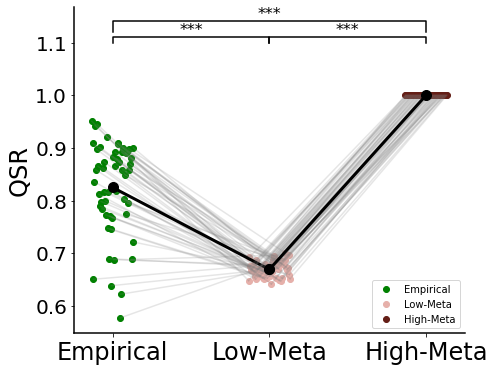

In [6]:
groups = ["Empirical", "Low-Meta", "High-Meta"]

plt.figure(figsize=(7, 6))


hm_syn_qsr = (
    high_syn_df.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
lm_syn_qsr = (
    low_syn_df.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
qsr_df = merge_result_df([human_qsr, lm_syn_qsr, hm_syn_qsr], groups, 200, subjects)

comparison_plot(
    qsr_df,
    "QSR",
    groups,
    "",
    [["Empirical", "Low-Meta"], ["Low-Meta", "High-Meta"], ["Empirical", "High-Meta"]],
    [1.1, 1.1, 1.12],
    [0.01, 0.01, 0.02],
    y_label="QSR",
)

plt.savefig("../figs/fake_agents_qsr.png", dpi=400)

In [124]:
def pval_symb(p):
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = "n.s"
    return sig_symbol


def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame()):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

In [154]:
def plot_regression_df(df,x, y, color, pos_x, pos_y, xlabel, ylabel):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)
    print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

    seaborn.regplot(data=df, x=x, y=y, color= color, label= "Forwarad Model")

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.text(pos_x, pos_y, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)

## Fit synthetic agents to Bakcward and Forward models

In [7]:
from Fitting import fit_for_all_subjects
from Forward import forward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 120
n_threads = 100

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, forward_fitting
)

hsyn_forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"]) * (
    hsyn_forward_df["bound_range"]
) + hsyn_forward_df["lbound"]

In [6]:
from Backward import backward_fitting


In [8]:
from Backward import backward_fitting

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, backward_fitting
)

hsyn_backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"]) * (
    hsyn_backward_df["bound_range"]
) + hsyn_backward_df["lbound"]

In [9]:
from Forward import simulate_with_params

df_lists = []
count = 0
for i in range(100):
    low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
    n_fitting = 100
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
    )

    lsyn_backward_df = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
        lsyn_backward_df["bound_range"]
    ) + lsyn_backward_df["lbound"]

    lsyn_backward_simulation_df = simulate_with_params(
        lsyn_backward_df, lv_induction_data, subjects
    )
    lsyn_backward_simulation_df["agent_nr"] = count
    df_lists.append(lsyn_backward_simulation_df)
    count += 1

Process ForkPoolWorker-445:
Process ForkPoolWorker-459:
Process ForkPoolWorker-481:
Process ForkPoolWorker-488:
Process ForkPoolWorker-457:
Process ForkPoolWorker-498:
Process ForkPoolWorker-496:
Process ForkPoolWorker-497:
Process ForkPoolWorker-492:
Process ForkPoolWorker-463:
Process ForkPoolWorker-499:
Process ForkPoolWorker-500:
Process ForkPoolWorker-495:
Process ForkPoolWorker-437:
Process ForkPoolWorker-483:
Process ForkPoolWorker-476:
Process ForkPoolWorker-471:
Process ForkPoolWorker-467:
Process ForkPoolWorker-482:
Process ForkPoolWorker-486:
Process ForkPoolWorker-473:
Process ForkPoolWorker-494:
Process ForkPoolWorker-493:
Process ForkPoolWorker-470:
Process ForkPoolWorker-485:
Process ForkPoolWorker-407:
Process ForkPoolWorker-487:
Process ForkPoolWorker-469:
Process ForkPoolWorker-455:
Process ForkPoolWorker-454:
Process ForkPoolWorker-474:
Process ForkPoolWorker-431:
Process ForkPoolWorker-461:
Process ForkPoolWorker-440:
Process ForkPoolWorker-478:
Process ForkPoolWork

  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Proces

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multi

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _boots

  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with s

  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*arg

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Keyb

  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 41, in backward_fitting
    fitting_result = minimize(backward_distance, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 41, in backward_fitting
    fitting_result = minimize(backward_distance, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 41, in backward_fitting
    fitting_result = minimize(backward_distance, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", li

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 41, in backward_fitting
    fitting_result = minimize(backward_distance, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 285, in fun_and_grad
    self._update_fun()
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 41, in backward_fitting
    fitting_result = minimize(backward_distance, x0=params0, args=(resps, rewards, confs), bounds=params_ra

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
    self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
    self._update_fun_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
    self._update_fun_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 285, in fun_and_grad
    self._update_fun()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 496, in approx_derivative
    h, use_one_sided = _adjust_scheme_to_bounds(
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 17, in backward_distance
    choices_probability = softmax_func(Q, beta)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 576

KeyboardInterrupt
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 17, in backward_distance
    choices_probability = softmax_func(Q, beta)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/home/agholamzadeh/jupyter/meta-meassure/notebooks/../functions/Backward.py", line 20, in backward_distance
    Q[resps[t]] = Q[resps[t]] + alpha * prediction_error
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
KeyboardInterrupt
  File "/usr/local/lib/python3.8/dist-packages/sc

KeyboardInterrupt: 

In [ ]:
lm_backward_simulation_df = pd.concat(df_lists, axis=0, ignore_index=True)
lm_var_df = (
    lm_backward_simulation_df.groupby(["sub", "agent_nr"])
    .agg({"cor": "mean"})
    .reset_index()
    .groupby(["sub"])["cor"]
    .apply(scipy.stats.sem)
    .reset_index()
)


In [ ]:
noise_to_df_dict = {}
noise_stds = [1 ,2]
for noise in noise_stds:
    df_lists = []
    count = 0
    for i in range(30):
        low_syn_df["cj"] = add_noise_to_conf(high_syn_df["cj"], 0, noise)
        n_fitting = 60
        n_threads = 100
        
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
        )
        
        lsyn_backward_df = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
            lsyn_backward_df["bound_range"]
        ) + lsyn_backward_df["lbound"]

        lsyn_backward_simulation_df = simulate_with_params(
            lsyn_backward_df, lv_induction_data, subjects
        )

        lsyn_backward_simulation_df["agent_nr"] = count

        df_lists.append(lsyn_backward_simulation_df)
        count += 1
    noise_to_df_dict[noise] = pd.concat(df_lists, axis=0, ignore_index=True)

In [10]:
from Forward import simulate_with_params

# hsyn_backward_simulation_df = simulate_with_params(
#     hsyn_backward_df, lv_induction_data, subjects
# )
hsyn_forward_simulation_df = simulate_with_params(
    hsyn_forward_df, lv_induction_data, subjects
)

groups = ["Forward", "Low-Meta", "High-Meta"]

fwd_avg_df = (
    hsyn_forward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

# hm_avg_df = (
#     hsyn_backward_simulation_df.rename(columns={"sub": "subject"})
#     .groupby("subject")
#     .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
#     .reset_index()
# )

# lm_avg_df = (
#     lsyn_backward_simulation_df.rename(columns={"sub": "subject"})
#     .groupby("subject")
#     .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
#     .reset_index()
# )

# avg_df = merge_result_df([fwd_avg_df, lm_avg_df, hm_avg_df], groups, 200, subjects)
# avg_df.rename(
#     columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
#     inplace=True,
# )

In [ ]:
fwd_avg_df

In [ ]:
plt.figure(figsize=(8, 7))

comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [["Forward", "Low-Meta"], ["Low-Meta", "High-Meta"], ["Forward", "High-Meta"]],
    [1, 1, 1.03],
    [0.01, 0.01, 0.02],
    y_label="Performance",
    legend="upper right",
    var_df=lsyn_var_df,
)
# plt.savefig("../figs/fake_agents_accuracy.png", dpi=400)

## Fake Agents Spectrum Fitting

In [ ]:
%%time
import functools
from Fake_Agent import noisy_agent

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]

n_reps = 1  # number of fake agents for each variance
n_fitting = 10  # number of fitting per fake agent
n_threads = 4  # number of async threads for fitting

noise_vars = np.linspace(0, 4, 30)
cnt = 1
for subject_id in subjects:
    if subject_id in [45628, 45664, 45745, 45763, 45829, 45640, 45682, 45760, 45805]:
        continue

    partial_func = functools.partial(
        noisy_agent,
        n_reps=n_reps,
        n_fitting=n_fitting,
        data=lv_induction_data,
        params_ranges=params_ranges,
        subject_id=subject_id,
        subjects=subjects,
    )
    with Pool(n_threads) as p:
        result = p.map(partial_func, noise_vars)
    result = np.array(result)
    noises = []
    noise_perfs_arr = []
    noise_metai_arr = []
    noise_qsr_arr = []
    noise_qsr_scaled_arr = []
    for i in range(n_reps):
        noises.extend(noise_vars)
        noise_perfs_arr.extend(result[:, 0, i])
        noise_metai_arr.extend(result[:, 1, i])
        noise_qsr_arr.extend(result[:, 2, i])
        noise_qsr_scaled_arr.extend(result[:, 3, i])
    noise_df = pd.DataFrame(
        list(
            zip(
                noises,
                noise_perfs_arr,
                noise_metai_arr,
                noise_qsr_arr,
                noise_qsr_scaled_arr,
            )
        ),
        columns=["noise_var", "perf", "metai", "QSR", "QSR_scaled"],
    )
    noise_df["subject"] = subject_id
    noise_df.to_csv("../results/fake_agents/noise_sub_" + str(subject_id) + ".csv")

## Fake Agents Spectrum Analysis

In [ ]:
noise_df_list = []
for subject_id in subjects:
    if subject_id in [45628, 45664, 45745, 45763, 45829, 45640, 45682, 45760, 45805]:
        continue

    noise_df = pd.read_csv(
        "../results/fake_agents/noise_sub_" + str(subject_id) + ".csv"
    )
    noise_df_list.append(noise_df)
df = pd.concat(noise_df_list, axis=0, ignore_index=True)

In [ ]:
fwd_avg_df["cor"].mean()

In [ ]:
plt.figure(figsize=(9, 7))

noise_sub_df = (
    df.groupby(["subject", "noise_var"]).mean(["perf", "metai"]).reset_index()
)
rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="perf",
    color="red",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

plt.axhline(fwd_averg_perf, linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (-1, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)


# plt.gca().invert_xaxis()

plt.xticks(range(1, 30, 3))

plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("Noise Variance", fontsize=24)
plt.ylabel("Performance", fontsize=24)
plt.savefig("../figs/noisy_agents_spect.png", dpi=400)

In [ ]:
plt.figure(figsize=(9, 7))

noise_sub_df = (
    df.groupby(["subject", "noise_var"]).mean(["perf", "metai"]).reset_index()
)
rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="perf",
    color="red",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

plt.axhline(fwd_averg_perf, linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (-1, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)

noise_sub_df = df.groupby(["subject", "noise_var"]).mean("QSR").reset_index()
rounded_df = noise_sub_df.round({"noise_var": 1})
seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="QSR",
    color="yellow",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="QSR",
)


noise_sub_df = df.groupby(["subject", "noise_var"]).mean("QSR_scaled").reset_index()
rounded_df = noise_sub_df.round({"noise_var": 1})
seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="QSR_scaled",
    color="orange",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="QSR_scaled",
)


plt.gca().invert_xaxis()

plt.xticks(range(1, 30, 3))

plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("Noise Variance", fontsize=24)
plt.ylabel("Performance", fontsize=24)
# plt.savefig("../figs/noisy_agents_qsr_spect.png".format(subject_id), dpi=400)

## Parameter Analysis of Fake Agents

In [ ]:
high_syn_df = lv_induction_data.copy()
high_syn_df["cj"] = np.where(high_syn_df["cor"] == 1, 5, 1)
low_syn_df = lv_induction_data.copy()
low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
human_qsr = (
    lv_induction_data.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)

In [ ]:
res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, backward_fitting
)

hsyn_backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"]) * (
    hsyn_backward_df["bound_range"]
) + hsyn_backward_df["lbound"]

In [ ]:
hsyn_backward_df.to_csv("../results/high_meta_params.csv")

In [ ]:
hsyn_backward_simulation_df = simulate_with_params(hsyn_backward_df, lv_induction_data, subjects)

In [ ]:
hsyn_backward_simulation_df.to_csv("../results/high_meta_simulation.csv")

## Noise Backward

In [10]:
def add_noise_to_conf(confs, mean,std):
    confs_cloned = confs.copy()
    noises =  np.random.normal(loc=mean, scale=std, size= len(confs))
    confs_cloned += noises
    confs_cloned[confs_cloned > 5] = 5
    confs_cloned[confs_cloned <1] =1
    return confs_cloned

### Continious noise spectrum

In [9]:
from Forward import simulate_with_params

noise_std_ls = np.linspace(0,4,10)
n_fitting = 40
n_threads = 120
params_df_list = []
simulations_df_list = []

for noise_std in noise_std_ls:
    noie_df = high_syn_df.copy()
    for i in range(20):
        if i % 5 == 0:
            print("iteration: {}, {}".format(i, noise_std))
        noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting
        )

        noise_params = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        noise_params["hbound"] = (5 - noise_params["lbound"]) * (
            noise_params["bound_range"]
        ) + noise_params["lbound"]

        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        
        params_df_list.append(noise_params)

        noise_simulation = simulate_with_params(
            noise_params, lv_induction_data, subjects, n = 100
        )

        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        
        simulations_df_list.append(noise_simulation)

noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)

    

iteration: 0, 0.0
iteration: 5, 0.0
iteration: 10, 0.0
iteration: 15, 0.0
iteration: 0, 0.4444444444444444
iteration: 5, 0.4444444444444444
iteration: 10, 0.4444444444444444
iteration: 15, 0.4444444444444444
iteration: 0, 0.8888888888888888
iteration: 5, 0.8888888888888888
iteration: 10, 0.8888888888888888
iteration: 15, 0.8888888888888888
iteration: 0, 1.3333333333333333
iteration: 5, 1.3333333333333333
iteration: 10, 1.3333333333333333
iteration: 15, 1.3333333333333333
iteration: 0, 1.7777777777777777
iteration: 5, 1.7777777777777777
iteration: 10, 1.7777777777777777
iteration: 15, 1.7777777777777777
iteration: 0, 2.2222222222222223
iteration: 5, 2.2222222222222223
iteration: 10, 2.2222222222222223
iteration: 15, 2.2222222222222223
iteration: 0, 2.6666666666666665
iteration: 5, 2.6666666666666665
iteration: 10, 2.6666666666666665
iteration: 15, 2.6666666666666665
iteration: 0, 3.1111111111111107
iteration: 5, 3.1111111111111107
iteration: 10, 3.1111111111111107
iteration: 15, 3.11111

In [11]:
from scipy.optimize import minimize
from Forward import *

def backward_distance3(params, resps, rewards, confs):
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3] * (5 - lbound) + lbound

    task_length = len(resps)
    init_confs = np.zeros(task_length)
    Q = np.array([.5, .5])
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        init_confs[t] = np.abs(Q[0] - Q[1])
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error
    
    min_conf = np.min(init_confs)
    max_conf = np.max(init_confs)
    model_confs = linear_transform_on_array(init_confs, [min_conf, max_conf], [lbound, hbound])
    dist = mean_square_distance(confs, model_confs)
    return dist


def backward_fitting3(dict_input):
    resps = dict_input["resps"]
    rewards = dict_input["rewards"]
    confs = dict_input["confs"]
    n_fitting = dict_input["n_fitting"]
    params_ranges = dict_input["params_ranges"]
    min_dist = np.inf
    neg_LL = 0
    dist_seq = np.zeros(n_fitting)
    neg_LL_seq = np.zeros(n_fitting)
    for j in range(n_fitting):
        params0 = np.zeros(len(params_ranges))
        for p in range(len(params_ranges)):
            params0[p] = (np.random.uniform(*params_ranges[p]))
        fitting_result = minimize(backward_distance3, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
        if fitting_result.success:
            if fitting_result.fun < min_dist:
                min_dist = fitting_result.fun
                fit_res = fitting_result.x
                neg_LL = forward_LL(fit_res, resps, rewards)
        dist_seq[j] = min_dist
        neg_LL_seq[j] = neg_LL
    return fit_res, neg_LL_seq, dist_seq

In [16]:
from scipy.optimize import minimize
from Forward import *

def backward_distance2(params, resps, rewards, confs):
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3] * (5 - lbound) + lbound

    task_length = len(resps)
    init_confs = np.zeros(task_length)
    Q = np.array([.5, .5])
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        init_confs[t] = Q[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error
    
    min_conf = np.min(init_confs)
    max_conf = np.max(init_confs)
    model_confs = linear_transform_on_array(init_confs, [min_conf, max_conf], [lbound, hbound])
    dist = mean_square_distance(confs, model_confs)
    return dist


def backward_fitting2(dict_input):
    resps = dict_input["resps"]
    rewards = dict_input["rewards"]
    confs = dict_input["confs"]
    n_fitting = dict_input["n_fitting"]
    params_ranges = dict_input["params_ranges"]
    min_dist = np.inf
    neg_LL = 0
    dist_seq = np.zeros(n_fitting)
    neg_LL_seq = np.zeros(n_fitting)
    for j in range(n_fitting):
        params0 = np.zeros(len(params_ranges))
        for p in range(len(params_ranges)):
            params0[p] = (np.random.uniform(*params_ranges[p]))
        fitting_result = minimize(backward_distance2, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
        if fitting_result.success:
            if fitting_result.fun < min_dist:
                min_dist = fitting_result.fun
                fit_res = fitting_result.x
                neg_LL = forward_LL(fit_res, resps, rewards)
        dist_seq[j] = min_dist
        neg_LL_seq[j] = neg_LL
    return fit_res, neg_LL_seq, dist_seq

In [12]:
from Forward import simulate_with_params

noise_std_ls = np.linspace(0,4,10)
n_fitting = 40
n_threads = 120
params_df_list = []
simulations_df_list = []

for noise_std in noise_std_ls:
    noie_df = high_syn_df.copy()
    for i in range(20):
        if i % 5 == 0:
            print("iteration: {}, {}".format(i, noise_std))
        noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting3
        )

        noise_params = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        noise_params["hbound"] = (5 - noise_params["lbound"]) * (
            noise_params["bound_range"]
        ) + noise_params["lbound"]

        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        
        params_df_list.append(noise_params)

        noise_simulation = simulate_with_params(
            noise_params, lv_induction_data, subjects, n = 100
        )

        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        
        simulations_df_list.append(noise_simulation)

noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)

noise_1_params.to_csv("../results/noise_1_params_model_3.csv")
noise_1_simulations.to_csv("../results/noise_1_simulations_model_3.csv")

iteration: 0, 0.0
iteration: 5, 0.0
iteration: 10, 0.0
iteration: 15, 0.0
iteration: 0, 0.4444444444444444
iteration: 5, 0.4444444444444444
iteration: 10, 0.4444444444444444
iteration: 15, 0.4444444444444444
iteration: 5, 0.8888888888888888
iteration: 10, 0.8888888888888888
iteration: 15, 0.8888888888888888
iteration: 0, 1.3333333333333333
iteration: 5, 1.3333333333333333
iteration: 10, 1.3333333333333333
iteration: 15, 1.3333333333333333
iteration: 0, 1.7777777777777777
iteration: 5, 1.7777777777777777
iteration: 10, 1.7777777777777777
iteration: 15, 1.7777777777777777
iteration: 0, 2.2222222222222223
iteration: 5, 2.2222222222222223
iteration: 10, 2.2222222222222223
iteration: 15, 2.2222222222222223
iteration: 0, 2.6666666666666665
iteration: 5, 2.6666666666666665
iteration: 10, 2.6666666666666665
iteration: 15, 2.6666666666666665
iteration: 0, 3.1111111111111107
iteration: 5, 3.1111111111111107
iteration: 10, 3.1111111111111107
iteration: 15, 3.1111111111111107
iteration: 0, 3.55555

In [110]:
noise_std_ls = np.linspace(0,4,10)
noise_std_ls

array([0.        , 0.44444444, 0.88888889, 1.33333333, 1.77777778,
       2.22222222, 2.66666667, 3.11111111, 3.55555556, 4.        ])

In [ ]:
from Forward import simulate_with_params

noise_std_ls = np.linspace(0,4,10)
n_fitting = 40
n_threads = 120
params_df_list = []
simulations_df_list = []

for noise_std in noise_std_ls:
    noie_df = high_syn_df.copy()
    for i in range(20):
        if i % 5 == 0:
            print("iteration: {}, {}".format(i, noise_std))
        noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting2
        )

        noise_params = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        noise_params["hbound"] = (5 - noise_params["lbound"]) * (
            noise_params["bound_range"]
        ) + noise_params["lbound"]

        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        
        params_df_list.append(noise_params)

        noise_simulation = simulate_with_params(
            noise_params, lv_induction_data, subjects, n = 100
        )

        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        
        simulations_df_list.append(noise_simulation)

noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)

noise_1_params.to_csv("../results/noise_1_params_model_2.csv")
noise_1_simulations.to_csv("../results/noise_1_simulations_model_2.csv")

iteration: 0, 0.0
iteration: 5, 0.0
iteration: 10, 0.0
iteration: 15, 0.0
iteration: 0, 0.4444444444444444
iteration: 5, 0.4444444444444444
iteration: 10, 0.4444444444444444
iteration: 15, 0.4444444444444444
iteration: 0, 0.8888888888888888
iteration: 5, 0.8888888888888888
iteration: 10, 0.8888888888888888


In [13]:
noise_1_params_model_1 = pd.read_csv("../results/noise_1_params.csv")
# noise_1_simulations_model_1 = pd.read_csv("../results/noise_1_simulations.csv")
# noise_sub_df_model1 = (
#     noise_1_simulations_model_1.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
# )


In [20]:
noise_sub_df_model1.to_csv("../results/noise_1_simulations_avg_model1.csv")

In [22]:
noise_1_params_model_2 = pd.read_csv("../results/noise_1_params_model_2.csv")
# noise_1_simulations_model_2 = pd.read_csv("../results/noise_1_simulations_model_2.csv")
# noise_sub_df_model2 = (
#     noise_1_simulations_model_2.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
# )

In [24]:
noise_sub_df_model2.to_csv("../results/noise_1_simulations_avg_model2.csv")

In [26]:
noise_1_params_model_3 = pd.read_csv("../results/noise_1_params_model_3.csv")
noise_1_simulations_model_3 = pd.read_csv("../results/noise_1_simulations_model_3.csv")
noise_sub_df_model3 = (
    noise_1_simulations_model_3.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
)
noise_sub_df_model3.to_csv("../results/noise_1_simulations_avg_model۳.csv")

In [62]:
fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf + .1/fwd_averg_perf

0.8954886588368245

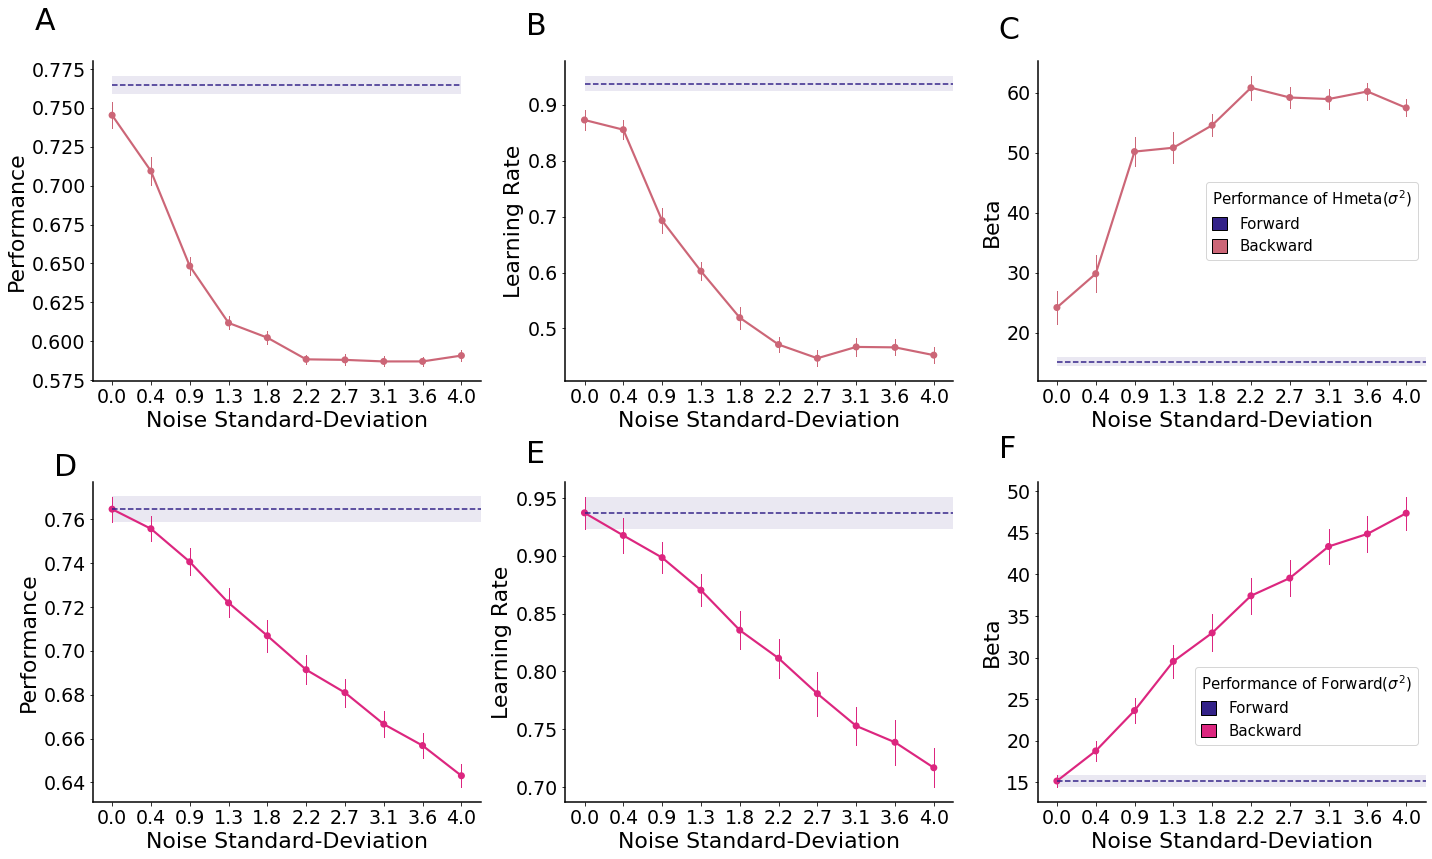

In [179]:
from matplotlib.ticker import FormatStrFormatter

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(20, 12))



plt.subplot(2,3,1)



noise_sub_df_model1 = pd.read_csv("../results/noise_1_simulations_avg_model1.csv")


plt.text(-2, .8, "A", fontsize=30)


fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=noise_sub_df_model1,
    x="noise",
    y="cor",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward",
    linestyles = ["-"],
    dodge = True
)


plt.axhline(fwd_averg_perf, xmin= .05,xmax = .95, linestyle="--", label="Forward", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        9,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Performance", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])




plt.subplot(2,3,2)

plt.text(-1.5, 1.025, "B", fontsize=30)


noise_sub_df_model_1 = (
    noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)


fwd_averg_perf = hsyn_forward_df["alpha"].mean()
fwd_averg_perf_se = hsyn_forward_df["alpha"].sem()

seaborn.pointplot(
    data=noise_sub_df_model_1,
    x="noise",
    y="alpha",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)


plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)



plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Learning Rate", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])



plt.subplot(2,3,3)

plt.text(-1.5, 69, "C", fontsize=30)

noise_sub_df_model_1 = (
    noise_1_params_model_1.groupby(["subject", "noise"]).mean(["beta"]).reset_index()
)


fwd_averg_perf = hsyn_forward_df["beta"].mean()
fwd_averg_perf_se = hsyn_forward_df["beta"].sem()

seaborn.pointplot(
    data=noise_sub_df_model_1,
    x="noise",
    y="beta",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Beta", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

legend = plt.legend(fontsize = 18, loc = 5, title = "Performance of Hmeta(sigma^2)", title_fontsize = 18)


handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#CC6677", edgecolor='black'))


legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward", "Backward"], handlelength=1, handleheight = 1,handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "right", title = r"Performance of Hmeta($\sigma^2$)", title_fontsize = 15)
legend._legend_box.align='left'




plt.subplot(2,3,4)

plt.text(-1.5, .78, "D", fontsize=30)


fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()
noise_sub_df_model1 = pd.read_csv("../results/forward_noise_1_simulations_avg_model1.csv")

seaborn.pointplot(
    data=noise_sub_df_model1,
    x="noise",
    y="cor",
    color="#DC267F",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward",
)

plt.axhline(fwd_averg_perf, xmin= .05, linestyle="--", label="Forward", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Performance", fontsize=22)


ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.subplot(2,3,5)

plt.text(-1.5, .98, "E", fontsize=30)

forward_noise_1_params_model_1 = pd.read_csv("../results/forward_noise_1_params.csv")

noise_sub_df = (
    forward_noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# rounded_df = noise_sub_df.round({"noise_var": 1})


fwd_averg_perf = hsyn_forward_df["alpha"].mean()
fwd_averg_perf_se = hsyn_forward_df["alpha"].sem()


seaborn.pointplot(
    data=noise_sub_df,
    x="noise",
    y="alpha",
    color="#DC267F",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="High meta to noisy",
)

plt.axhline(fwd_averg_perf, xmin = .05,  linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)



plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Learning Rate", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


plt.subplot(2,3,6)

plt.text(-1.5, 54, "F", fontsize=30)

noise_sub_df = (
    forward_noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = hsyn_forward_df["beta"].mean()
fwd_averg_perf_se = hsyn_forward_df["beta"].sem()

seaborn.pointplot(
    data=noise_sub_df,
    x="noise",
    y="beta",
    color="#DC267F",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="High meta to noisy",
)

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)

legend = plt.legend(fontsize = 18, loc = 3, title = "Performance of Forward(sigma^2)", title_fontsize = 18)

legend._legend_box.align='left'

handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#DC267F", edgecolor='black'))


legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward","Backward"], handlelength=1, handleheight = 1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "right", bbox_to_anchor=(1, .3), title = r"Performance of Forward($\sigma^2$)", title_fontsize = 15)
legend._legend_box.align='left'



plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Beta", fontsize=22)


ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.savefig("../figs/noise_agents.png", dpi=400, bbox_inches = "tight")


plt.show()

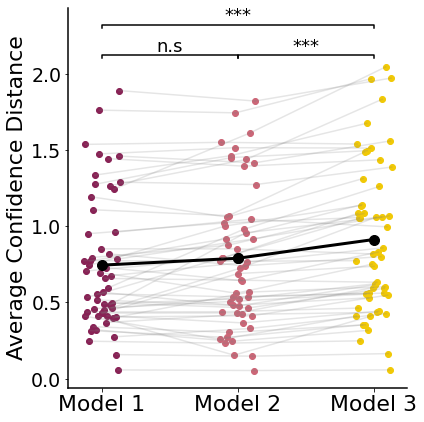

In [123]:
with open('myplot.pkl','rb') as fid:
    ax = pickle.load(fid)
plt.show()


Statistics for Model 1 and Model 2 =555.0, p=1.064e-01
Statistics for Model 2 and Model 3 =41.0, p=1.540e-09
Statistics for Model 1 and Model 3 =68.0, p=6.338e-09
mean Model 1 = 0.74
mean Model 2 = 0.79
mean Model 3 = 0.91


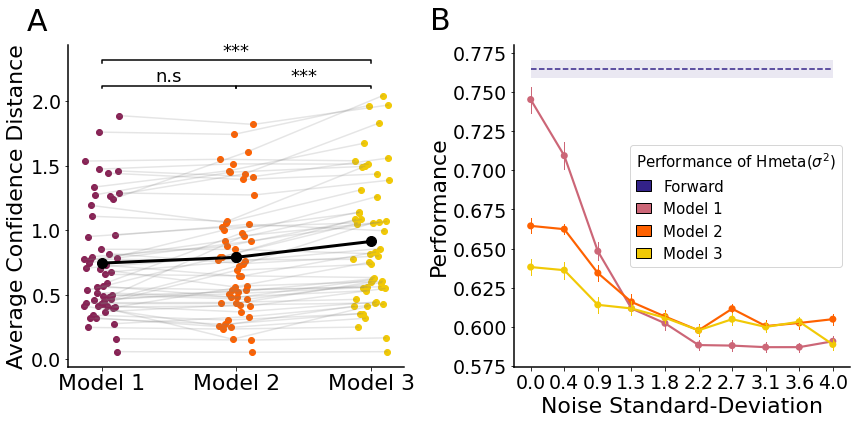

In [155]:
from matplotlib.ticker import FormatStrFormatter
import pickle

plt.figure(figsize=(12, 6))



plt.subplot(1,2,1)

plt.text(-83, 2.55, "A", fontsize=30)

color_dict = {"Model 1": "#882255", "Model 2" : "#FE6100", "Model 3": "#F1C906"}
conf_models_params_df = pd.read_csv("../results/conf_models_params.csv")
groups = ["Model 1", "Model 2", "Model 3"]

comparison_plot(
    conf_models_params_df,
    "Confidence Distance",
    groups,
    "",
    [["Model 1", "Model 2"], ["Model 2", "Model 3"], ["Model 1", "Model 3"]],
    [2.1, 2.1, 2.3],
    [0.02, .02, .02],
    y_label="Average Confidence Distance",
)

plt.subplot(1,2,2)

plt.text(-3, .79, "B", fontsize=30)


# rounded_df = noise_sub_df.round({"noise_var": 1})

noise_sub_df_model1 = pd.read_csv("../results/noise_1_simulations_avg_model1.csv")
noise_sub_df_model2 = pd.read_csv("../results/noise_1_simulations_avg_model2.csv")
noise_sub_df_model3 = pd.read_csv("../results/noise_1_simulations_avg_model۳.csv")


fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=noise_sub_df_model1,
    x="noise",
    y="cor",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward",
    linestyles = ["-"],
    dodge = True
)

seaborn.pointplot(
    data=noise_sub_df_model2,
    x="noise",
    y="cor",
    color="#FE6100",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label = "model 2"
)

seaborn.pointplot(
    data=noise_sub_df_model3,
    x="noise",
    y="cor",
    color="#F1C906",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label = "model 3"
)

plt.axhline(fwd_averg_perf, xmin= .05,xmax = .95, linestyle="--", label="Forward", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        9,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Performance", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])



handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#CC6677", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#FE6100", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#F1C906", edgecolor='black'))



legend = ax.legend(handles=[tuple(handles[::4]), tuple(handles[1::4]), tuple(handles[2::4]), tuple(handles[3::4])], labels=["Forward", "Model 1", "Model 2", "Model 3"], handlelength=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "right", title = r"Performance of Hmeta($\sigma^2$)", title_fontsize = 15)
legend._legend_box.align='left'

plt.tight_layout()

plt.savefig("../figs/Conf_rep.png", dpi=400, bbox_inches = "tight")


(p = 2.35e-01, r = -0.16,ci = [-0.41,0.11])
(p = 8.02e-07, r = -0.61,ci = [-0.76,-0.41])
(p = 2.86e-03, r = -0.40,ci = [-0.60,-0.15])
(p = 5.78e-02, r = -0.26,ci = [-0.49,0.01])
(p = 2.37e-01, r = -0.16,ci = [-0.41,0.11])
(p = 3.76e-06, r = -0.58,ci = [-0.74,-0.37])


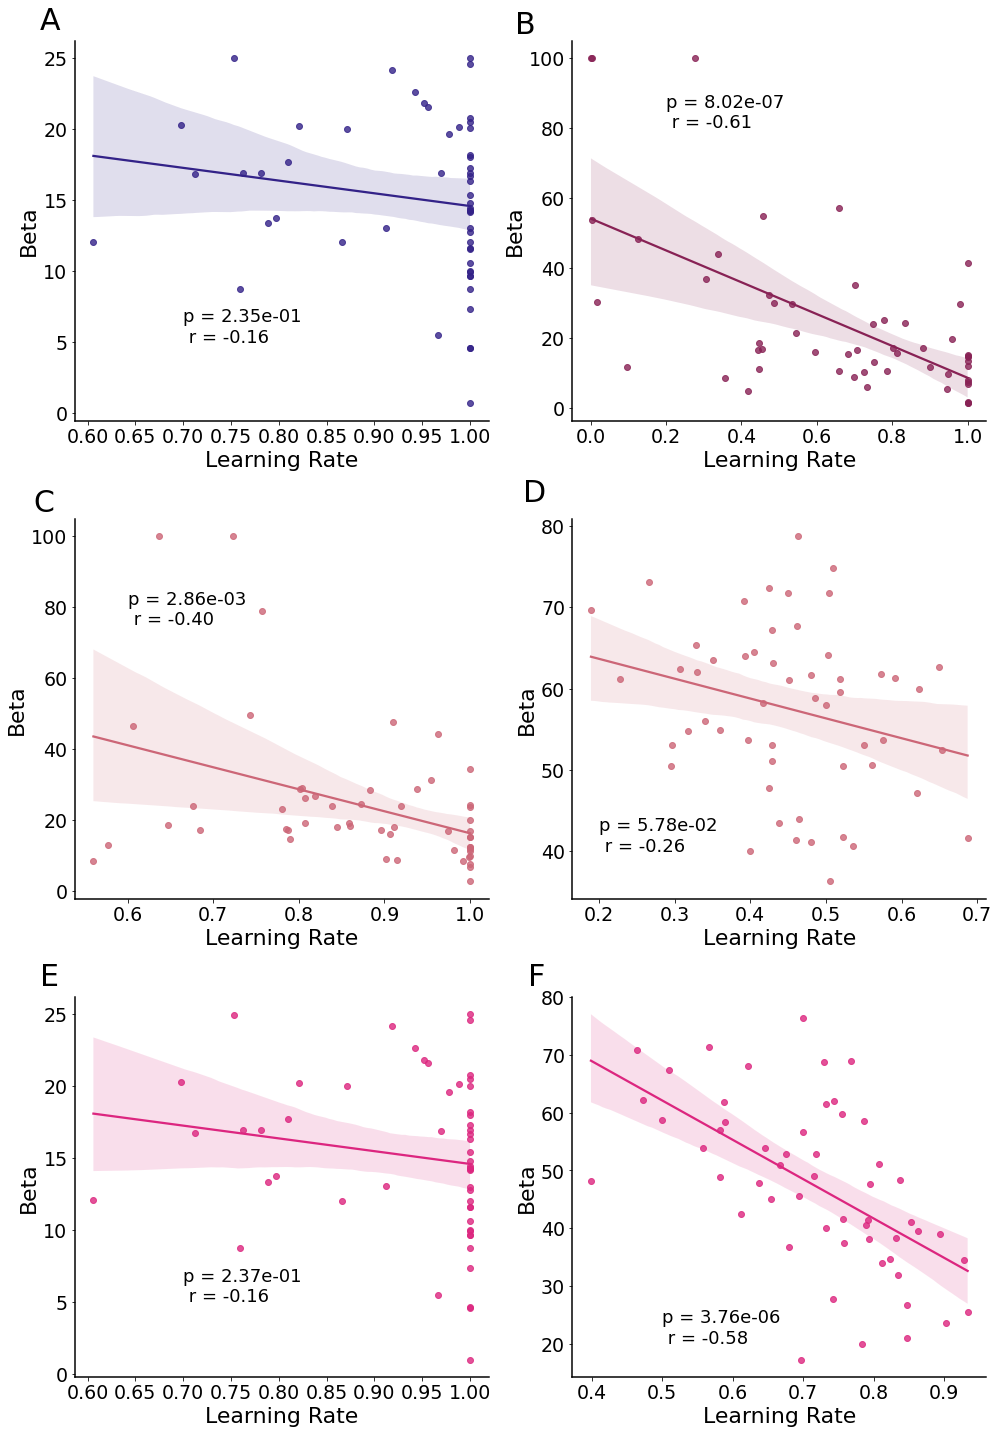

In [206]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(14, 20))



plt.subplot(3,2,1)
plt.text(.55, 27, "A", fontsize=30)

forward_df = pd.read_csv("../results/forward_df.csv")
plot_regression_df(forward_df,"alpha", "beta", "#332288", .7, 5, "Learning Rate", "Beta")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places


plt.subplot(3,2,2)
plt.text(-.2, 107, "B", fontsize=30)

backward_df = pd.read_csv("../results/backward_df.csv")
plot_regression_df(backward_df,"alpha", "beta", "#882255", .2, 80, "Learning Rate", "Beta")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places

plt.subplot(3,2,3)
plt.text(.49, 107, "C", fontsize=30)

temp_df_noise =noise_1_params_model_1[noise_1_params_model_1["noise"] == 0]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()

plot_regression_df(temp_df,"alpha", "beta", "#CC6677", .6, 75, "Learning Rate", "Beta")


plt.subplot(3,2,4)
plt.text(.1, 83, "D", fontsize=30)

temp_df_noise =noise_1_params_model_1[noise_1_params_model_1["noise"] == 4]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()

plot_regression_df(temp_df,"alpha", "beta", "#CC6677", .2, 40, "Learning Rate", "Beta")


plt.subplot(3,2,5)
plt.text(.55, 27, "E", fontsize=30)

temp_df_noise =forward_noise_1_params_model_1[forward_noise_1_params_model_1["noise"] == 0]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()
plot_regression_df(temp_df,"alpha", "beta", "#DC267F", .7, 5, "Learning Rate", "Beta")


plt.subplot(3,2,6)

plt.text(.31, 82, "F", fontsize=30)


temp_df_noise =forward_noise_1_params_model_1[forward_noise_1_params_model_1["noise"] == 4]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()
plot_regression_df(temp_df,"alpha", "beta", "#DC267F", .5, 20, "Learning Rate", "Beta")



plt.tight_layout()

plt.savefig("../figs/Alpha-Beta-cor.png", dpi=400, bbox_inches = "tight")


plt.show()


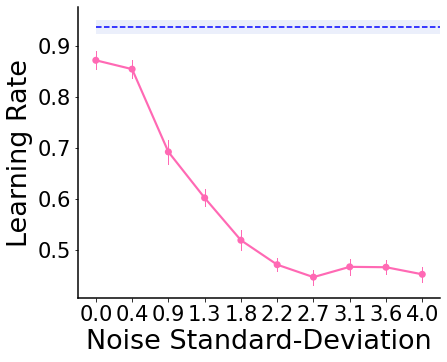

In [32]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(6.5, 5.35))

noise_sub_df_model_1 = (
    noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# noise_sub_df_model_2 = (
#     noise_1_params_model_2.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
# )

# noise_sub_df_model_3 = (
#     noise_1_params_model_3.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
# )

# rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = hsyn_forward_df["alpha"].mean()
fwd_averg_perf_se = hsyn_forward_df["alpha"].sem()

seaborn.pointplot(
    data=noise_sub_df_model_1,
    x="noise",
    y="alpha",
    color="#ff69b4",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

# seaborn.pointplot(
#     data=noise_sub_df_model_2,
#     x="noise",
#     y="alpha",
#     color="#F89880",
#     errwidth=1,
#     scale=0.8,
#     errorbar="se",
#     label="Backward Model",
# )

# seaborn.pointplot(
#     data=noise_sub_df_model_3,
#     x="noise",
#     y="alpha",
#     color="#f0e130",
#     errwidth=1,
#     scale=0.8,
#     errorbar="se",
#     label="Backward Model",
# )

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=21)
plt.yticks(fontsize=21)


plt.xlabel("Noise Standard-Deviation", fontsize=27)
plt.ylabel("Learning Rate", fontsize=27)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.savefig("../figs/High_meta_to_noisy_alpha.png", dpi=400,  bbox_inches = "tight")

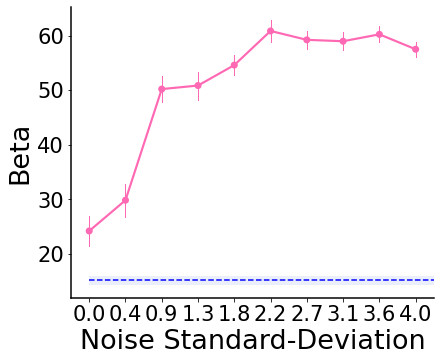

In [33]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(6.5, 5.35))

noise_sub_df_model_1 = (
    noise_1_params_model_1.groupby(["subject", "noise"]).mean(["beta"]).reset_index()
)

# noise_sub_df_model_2 = (
#     noise_1_params_model_2.groupby(["subject", "noise"]).mean(["beta"]).reset_index()
# )

# noise_sub_df_model_3 = (
#     noise_1_params_model_3.groupby(["subject", "noise"]).mean(["beta"]).reset_index()
# )

# rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = hsyn_forward_df["beta"].mean()
fwd_averg_perf_se = hsyn_forward_df["beta"].sem()

seaborn.pointplot(
    data=noise_sub_df_model_1,
    x="noise",
    y="beta",
    color="#ff69b4",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

# seaborn.pointplot(
#     data=noise_sub_df_model_2,
#     x="noise",
#     y="beta",
#     color="#F89880",
#     errwidth=1,
#     scale=0.8,
#     errorbar="se",
#     label="Backward Model",
# )

# seaborn.pointplot(
#     data=noise_sub_df_model_3,
#     x="noise",
#     y="beta",
#     color="#f0e130",
#     errwidth=1,
#     scale=0.8,
#     errorbar="se",
#     label="Backward Model",
# )

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=21)
plt.yticks(fontsize=21)


plt.xlabel("Noise Standard-Deviation", fontsize=27)
plt.ylabel("Beta", fontsize=27)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.savefig("../figs/High_meta_to_noisy_beta.png", dpi=400,bbox_inches = "tight")

(p = 2.86e-03, r = -0.40,ci = [-0.60,-0.15])


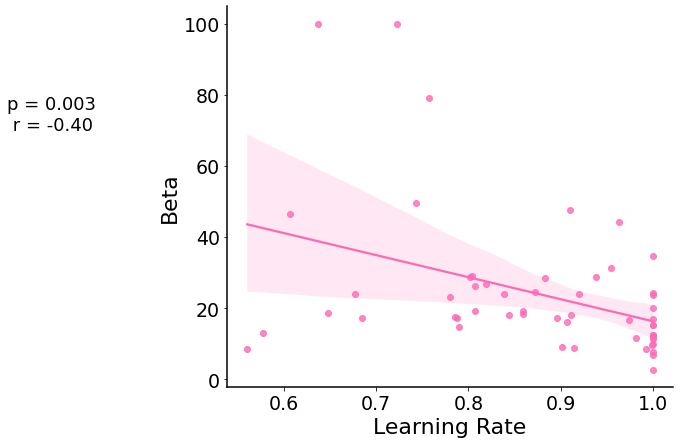

In [107]:
temp_df_noise =noise_1_params_model_1[noise_1_params_model_1["noise"] == 0]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()

plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(temp_df["alpha"], temp_df["beta"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=temp_df, x="alpha", y="beta", color="#ff69b4")

plt.ylabel("Beta", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.3, 70, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/High_meta_params_corrleation_noise4.png", dpi=400)


plt.show()

In [18]:
noise_std_ls = np.linspace(0,4,10)

noise_std_ls

array([0.        , 0.44444444, 0.88888889, 1.33333333, 1.77777778,
       2.22222222, 2.66666667, 3.11111111, 3.55555556, 4.        ])

In [11]:
simulations_df_list[0]

,sub,run,resp,reward,cor,cj,Q1,Q2,agent_nr
0,45628,0,0,0.625872,1.0,3.863131,0.500000,0.500000,1
1,45628,0,0,0.531705,1.0,4.055284,0.625872,0.500000,1
2,45628,0,1,0.395744,0.0,3.808993,0.531705,0.500000,1
3,45628,0,0,0.657494,1.0,4.066944,0.531705,0.395744,1
4,45628,0,0,0.750121,1.0,4.161233,0.657494,0.395744,1
...,...,...,...,...,...,...,...,...,...
2159995,47743,99,0,0.314838,0.0,4.180781,0.511639,0.261531,1
2159996,47743,99,0,0.361774,0.0,4.039216,0.314838,0.261531,1
2159997,47743,99,0,0.366887,0.0,4.135763,0.361774,0.261531,1
2159998,47743,99,0,0.424627,0.0,4.141412,0.366887,0.261531,1


### Noise 1

In [10]:
from Forward import simulate_with_params

noie_df = high_syn_df.copy()
noise_std = 2
n_fitting = 50
n_threads = 100
params_df_list = []
simulations_df_list = []
count = 1
for i in range(1):
    print("iteration: {}".format(i))
    noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting
    )

    noise_params = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    noise_params["hbound"] = (5 - noise_params["lbound"]) * (
        noise_params["bound_range"]
    ) + noise_params["lbound"]

    noise_params["agent_nr"] = count
    
    params_df_list.append(noise_params)
    
    noise_simulation = simulate_with_params(
        noise_params, lv_induction_data, subjects
    )
    
    noise_simulation["agent_nr"] = count
    simulations_df_list.append(noise_simulation)
    
    count += 1
noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)


iteration: 0


In [ ]:
noise_simulation

In [11]:
noise_1_params.to_csv("../results/noise_1_params.csv")
noise_1_simulations.to_csv("../results/noise_1_simulations.csv")

In [25]:
1+1

2

In [ ]:
noise_1_params_model = pd.read_csv("../results/noise_1_params.csv")
noise_1_simulations = pd.read_csv("../results/noise_1_simulations.csv")

### Noise 2

In [ ]:
noise_std = 4
n_fitting = 60
n_threads = 100
params_df_list = []
simulations_df_list = []
count = 1
for i in range(30):
    print("iteration: {}".format(i))
    noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting
    )

    noise_params = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    noise_params["hbound"] = (5 - noise_params["lbound"]) * (
        noise_params["bound_range"]
    ) + noise_params["lbound"]

    noise_params["agent_nr"] = count
    
    params_df_list.append(noise_params)
    
    noise_simulation = simulate_with_params(
        noise_params, lv_induction_data, subjects
    )
    
    noise_simulation["agent_nr"] = count
    simulations_df_list.append(noise_simulation)
    
    count += 1
noise_2_params = pd.concat(params_df_list, axis=0, ignore_index=True)
noise_2_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)


In [ ]:
noise_2_params.to_csv("../results/noise_2_params.csv")
noise_2_simulations.to_csv("../results/noise_2_simulations.csv")

In [ ]:
noise_2_params = pd.read_csv("../results/noise_2_params.csv")
noise_2_simulations = pd.read_csv("../results/noise_2_simulations.csv")

## Noise Forward

In [ ]:
params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 120
n_threads = 60

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, forward_fitting
)

hsyn_forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"]) * (
    hsyn_forward_df["bound_range"]
) + hsyn_forward_df["lbound"]



In [ ]:
forward_simulate_df = simulate_with_params(hsyn_forward_df, lv_induction_data, subjects)

## Noise 1

In [12]:
from Forward import simulate_agent
def simulate_with_params_one(params_df, data, subjects):
    df_lists = []
    for i, row in params_df.iterrows():
        params = [row["alpha"], row["beta"], row["lbound"], row["hbound"]]
        subject = int(row["subject"])
        trials_info = get_subject_task(data, subject)
        for run in range(1):
            resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)
            subject_list = [subject] * (len(resps))
            run_list = [run] * (len(resps))
            df = pd.DataFrame(zip(subject_list, run_list,resps, rewards, acc, confs, Q_list[:, 0], Q_list[:, 1]),
                          columns=["sub", "run", "resp", "reward", "cor", "cj", "Q1", "Q2"])
        df_lists.append(df)
    return pd.concat(df_lists, axis=0, ignore_index=True)



In [13]:
from Forward import simulate_with_params

noise_std_ls = np.linspace(0,4,10)
n_fitting = 40
n_threads = 120
params_df_list = []
simulations_df_list = []

for noise_std in noise_std_ls:
    for i in range(20):
        noie_df = simulate_with_params_one(hsyn_forward_df, lv_induction_data, subjects)
        if i % 5 == 0:
            print("iteration: {}, {}".format(i, noise_std))
        noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting
        )

        noise_params = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        noise_params["hbound"] = (5 - noise_params["lbound"]) * (
            noise_params["bound_range"]
        ) + noise_params["lbound"]

        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        
        params_df_list.append(noise_params)

        noise_simulation = simulate_with_params(
            noise_params, lv_induction_data, subjects, n = 30
        )

        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        
        simulations_df_list.append(noise_simulation)

forward_noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
forward_noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)


iteration: 0, 0.0
iteration: 5, 0.0
iteration: 10, 0.0
iteration: 15, 0.0
iteration: 0, 0.4444444444444444
iteration: 5, 0.4444444444444444
iteration: 10, 0.4444444444444444
iteration: 15, 0.4444444444444444
iteration: 0, 0.8888888888888888
iteration: 5, 0.8888888888888888
iteration: 10, 0.8888888888888888
iteration: 15, 0.8888888888888888
iteration: 0, 1.3333333333333333
iteration: 5, 1.3333333333333333
iteration: 10, 1.3333333333333333
iteration: 15, 1.3333333333333333
iteration: 0, 1.7777777777777777
iteration: 5, 1.7777777777777777
iteration: 10, 1.7777777777777777
iteration: 15, 1.7777777777777777
iteration: 0, 2.2222222222222223
iteration: 5, 2.2222222222222223
iteration: 10, 2.2222222222222223
iteration: 15, 2.2222222222222223
iteration: 0, 2.6666666666666665
iteration: 5, 2.6666666666666665
iteration: 10, 2.6666666666666665
iteration: 15, 2.6666666666666665
iteration: 0, 3.1111111111111107
iteration: 5, 3.1111111111111107
iteration: 10, 3.1111111111111107
iteration: 15, 3.11111

In [99]:
forward_noise_1_params_model_1 = pd.read_csv("../results/forward_noise_1_params.csv")
noise_1_simulations_model_1 = pd.read_csv("../results/forward_noise_1_simulations.csv")
noise_sub_df_model1 = (
    noise_1_simulations_model_1.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
)

noise_sub_df_model1.to_csv("../results/forward_noise_1_simulations_avg_model1.csv")

noise_1_params_model_2 = pd.read_csv("../results/forward_noise_1_params_model2.csv")
noise_1_simulations_model_2 = pd.read_csv("../results/forward_noise_1_simulations_model2.csv")
noise_sub_df_model2 = (
    noise_1_simulations_model_2.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
)

noise_sub_df_model2.to_csv("../results/forward_noise_1_simulations_avg_model2.csv")


noise_1_params_model_3 = pd.read_csv("../results/forward_noise_1_params_model3.csv")
noise_1_simulations_model_3 = pd.read_csv("../results/forward_noise_1_simulations_model3.csv")
noise_sub_df_model3 = (
    noise_1_simulations_model_3.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
)

noise_sub_df_model3.to_csv("../results/forward_noise_1_simulations_avg_model3.csv")

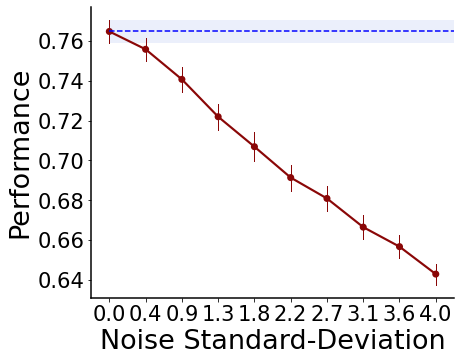

In [34]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(6.5, 5.35))


# rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()
noise_sub_df_model1 = pd.read_csv("../results/forward_noise_1_simulations_avg_model1.csv")

seaborn.pointplot(
    data=noise_sub_df_model1,
    x="noise",
    y="cor",
    color="#8A0707",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward",
)

# seaborn.pointplot(
#     data=noise_sub_df_model2,
#     x="noise",
#     y="cor",
#     color="#8A0707",
#     errwidth=1,
#     scale=0.8,
#     errorbar="se",
#     label="High meta to noisy",
# )

# seaborn.pointplot(
#     data=noise_sub_df_model3,
#     x="noise",
#     y="cor",
#     color="#8A0707",
#     errwidth=1,
#     scale=0.8,
#     errorbar="se",
#     label="High meta to noisy",
# )

plt.axhline(fwd_averg_perf, xmin= .05, linestyle="--", label="Forward", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=21)
plt.yticks(fontsize=21)


plt.xlabel("Noise Standard-Deviation", fontsize=27)
plt.ylabel("Performance", fontsize=27)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

# legend = plt.legend(fontsize = 18, loc = 3, title = "Performance of Forward(sigma^2)", title_fontsize = 18)

# legend._legend_box.align='left'

# handles = []

# handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="blue", edgecolor='black'))
# handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#8A0707", edgecolor='black'))


# legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward","Backward"], handlelength=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left", title = r"Performance of Forward($\sigma^2$)", title_fontsize = 15)
# legend._legend_box.align='left'



plt.savefig("../figs/forward_to_noisy_perf.png", dpi=400, bbox_inches='tight')


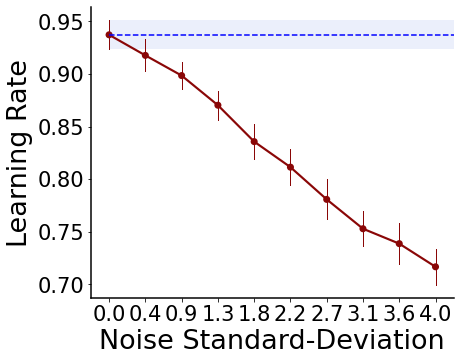

In [35]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(6.5, 5.35))

forward_noise_1_params_model_1 = pd.read_csv("../results/forward_noise_1_params.csv")

noise_sub_df = (
    forward_noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# rounded_df = noise_sub_df.round({"noise_var": 1})


fwd_averg_perf = hsyn_forward_df["alpha"].mean()
fwd_averg_perf_se = hsyn_forward_df["alpha"].sem()


seaborn.pointplot(
    data=noise_sub_df,
    x="noise",
    y="alpha",
    color="#8A0707",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="High meta to noisy",
)

plt.axhline(fwd_averg_perf, xmin = .05,  linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)



plt.xticks(fontsize=21)
plt.yticks(fontsize=21)


plt.xlabel("Noise Standard-Deviation", fontsize=27)
plt.ylabel("Learning Rate", fontsize=27)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.savefig("../figs/forward_to_noisy_alpha.png", dpi=400,  bbox_inches='tight')

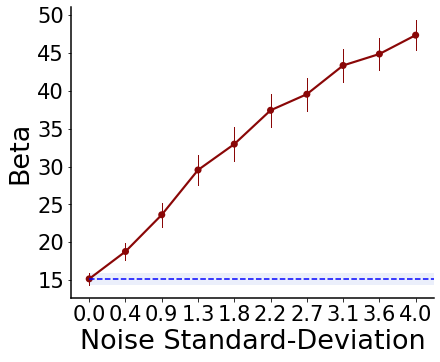

In [36]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(6.5, 5.35))

noise_sub_df = (
    forward_noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = hsyn_forward_df["beta"].mean()
fwd_averg_perf_se = hsyn_forward_df["beta"].sem()

seaborn.pointplot(
    data=noise_sub_df,
    x="noise",
    y="beta",
    color="#8A0707",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="High meta to noisy",
)

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)



plt.xlabel("Noise Standard-Deviation", fontsize=27)
plt.ylabel("Beta", fontsize=27)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.savefig("../figs/forward_to_noisy_beta.png", dpi=400, bbox_inches='tight')

(p = 3.76e-06, r = -0.58,ci = [-0.74,-0.37])


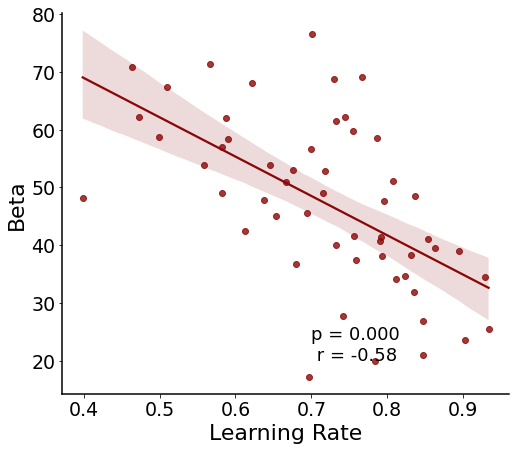

In [104]:
temp_df_noise =forward_noise_1_params_model_1[forward_noise_1_params_model_1["noise"] == 4]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()

plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(temp_df["alpha"], temp_df["beta"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=temp_df, x="alpha", y="beta", color="#8A0707")

plt.ylabel("Beta", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.7, 20, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/forward_params_corrleation_noise4.png", dpi=400)


plt.show()

In [ ]:
noise_std = 2
n_fitting = 60
n_threads = 16
params_df_list = []
simulations_df_list = []
count = 1
for i in range(30):
    noie_df = simulate_with_params_one(hsyn_forward_df, lv_induction_data, subjects)
    print("iteration: {}".format(i))
    noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting
    )

    noise_params = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    noise_params["hbound"] = (5 - noise_params["lbound"]) * (
        noise_params["bound_range"]
    ) + noise_params["lbound"]

    noise_params["agent_nr"] = count
    
    params_df_list.append(noise_params)
    
    noise_simulation = simulate_with_params(
        noise_params, lv_induction_data, subjects
    )
    
    noise_simulation["agent_nr"] = count
    simulations_df_list.append(noise_simulation)
    
    count += 1
forward_noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
forward_noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)


In [14]:
forward_noise_1_params.to_csv("../results/forward_noise_1_params.csv")
forward_noise_1_simulations.to_csv("../results/forward_noise_1_simulations.csv")

In [ ]:
from Forward import simulate_with_params

noise_std_ls = np.linspace(0,4,10)
n_fitting = 40
n_threads = 120
params_df_list = []
simulations_df_list = []

for noise_std in noise_std_ls:
    for i in range(20):
        noie_df = simulate_with_params_one(hsyn_forward_df, lv_induction_data, subjects)
        if i % 5 == 0:
            print("iteration: {}, {}".format(i, noise_std))
        noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting3
        )

        noise_params = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        noise_params["hbound"] = (5 - noise_params["lbound"]) * (
            noise_params["bound_range"]
        ) + noise_params["lbound"]

        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        
        params_df_list.append(noise_params)

        noise_simulation = simulate_with_params(
            noise_params, lv_induction_data, subjects, n = 30
        )

        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        
        simulations_df_list.append(noise_simulation)

forward_noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
forward_noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)

forward_noise_1_params.to_csv("../results/forward_noise_1_params_model3.csv")
forward_noise_1_simulations.to_csv("../results/forward_noise_1_simulations_model3.csv")

iteration: 0, 0.0


In [ ]:
from Forward import simulate_with_params

noise_std_ls = np.linspace(0,4,10)
n_fitting = 40
n_threads = 120
params_df_list = []
simulations_df_list = []

for noise_std in noise_std_ls:
    for i in range(20):
        noie_df = simulate_with_params_one(hsyn_forward_df, lv_induction_data, subjects)
        if i % 5 == 0:
            print("iteration: {}, {}".format(i, noise_std))
        noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting2
        )

        noise_params = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        noise_params["hbound"] = (5 - noise_params["lbound"]) * (
            noise_params["bound_range"]
        ) + noise_params["lbound"]

        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        
        params_df_list.append(noise_params)

        noise_simulation = simulate_with_params(
            noise_params, lv_induction_data, subjects, n = 30
        )

        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        
        simulations_df_list.append(noise_simulation)

forward_noise_1_params = pd.concat(params_df_list, axis=0, ignore_index=True)
forward_noise_1_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)

forward_noise_1_params.to_csv("../results/forward_noise_1_params_model2.csv")
forward_noise_1_simulations.to_csv("../results/forward_noise_1_simulations_model2.csv")

### Noise 2

In [ ]:
noise_std = 4
n_fitting = 60
n_threads = 100
params_df_list = []
simulations_df_list = []
count = 1
for i in range(30):
    noie_df = simulate_with_params_one(hsyn_forward_df, lv_induction_data, subjects)
    print("iteration: {}".format(i))
    noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, noie_df, backward_fitting
    )

    noise_params = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    noise_params["hbound"] = (5 - noise_params["lbound"]) * (
        noise_params["bound_range"]
    ) + noise_params["lbound"]

    noise_params["agent_nr"] = count
    
    params_df_list.append(noise_params)
    
    noise_simulation = simulate_with_params(
        noise_params, lv_induction_data, subjects
    )
    
    noise_simulation["agent_nr"] = count
    simulations_df_list.append(noise_simulation)
    
    count += 1
forward_noise_2_params = pd.concat(params_df_list, axis=0, ignore_index=True)
forward_noise_2_simulations = pd.concat(simulations_df_list, axis=0, ignore_index=True)


In [ ]:
forward_noise_2_params.to_csv("../results/forward_noise_2_params.csv")
forward_noise_2_simulations.to_csv("../results/forward_noise_2_simulations.csv")

In [ ]:
noise_1_params

In [ ]:
## sems
noise_1_sem = (
noise_1_params.groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)   

noise_2_sem = (
noise_2_params.groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)   

forward_noise_1_sem = (
forward_noise_1_params.groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)   

forward_noise_2_sem = (
forward_noise_2_params.groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)   

## avg_df

fwd_avg_df = (
    hsyn_forward_df
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

hm_avg_df = (
    hsyn_backward_df
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

noise1_avg_df = (
    noise_1_params
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

noise2_avg_df = (
    noise_2_params
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

forward_noise1_avg_df = (
    forward_noise_1_params
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

forward_noise2_avg_df = (
    forward_noise_2_params
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)


groups = ["Forward_Noise_2", "Forward_Noise_1", "Forward", "Noise_2", "Noise_1", "High-Meta"]
sem_groups = ["Forward_Noise_2", "Forward_Noise_1", "Noise_2", "Noise_1"]


avg_df = merge_result_df([forward_noise2_avg_df, forward_noise1_avg_df, fwd_avg_df, noise2_avg_df, noise1_avg_df, hm_avg_df], groups, 200, subjects)
sem_df = merge_result_df([forward_noise_2_sem, forward_noise_1_sem, noise_2_sem, noise_1_sem], sem_groups, 200, subjects)

In [ ]:
groups = ["Forward_Noise_2", "Forward_Noise_1", "Forward", "Noise_2", "Noise_1", "High-Meta"]
sem_groups = ["Forward_Noise_2", "Forward_Noise_1", "Noise_2", "Noise_1"]

forward_groups = groups[:3].copy()[::-1]
backward_groups = groups[3:].copy()[::-1]

forward_sem = sem_groups[:2][::-1]
backward_sem = sem_groups[2:][::-1]

forward_avg_sim_df = merge_result_df([fwd_avg_df, forward_noise1_avg_df, forward_noise2_avg_df], forward_groups, 100, subjects)
forward_sem_sim_df = merge_result_df([forward_noise_1_sem, forward_noise_2_sem], forward_sem, 200, subjects)

backward_avg_sim_df = merge_result_df([hm_avg_df, noise1_avg_df, noise2_avg_df], backward_groups, 100, subjects)
backward_sem_sim_df = merge_result_df([noise_1_sem, noise_2_sem], backward_sem, 200, subjects)


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2, 1)

comparison_plot(
    forward_avg_sim_df,
    "alpha",
    forward_groups,
    "",
    [["Forward_Noise_2", "Forward_Noise_1"], ["Forward_Noise_1", "Forward"]],
    [1.1, 1.1, 1.1, 1.1, 1.1],
    [0.02, 0.02, 0.02, 0.02, 0.02],
    y_label="Learning Rate",
    legend="lower right",
    var_df= forward_sem_sim_df
)

plt.subplot(1,2, 2)

comparison_plot(
    backward_avg_sim_df,
    "alpha",
    backward_groups,
    "",
    [["High-Meta", "Noise_1"], ["Noise_1", "Noise_2"]],
    [1.1, 1.1, 1.1, 1.1, 1.1],
    [0.02, 0.02, 0.02, 0.02, 0.02],
    y_label="Learning Rate",
    legend="lower right",
    var_df= backward_sem_sim_df
)

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2, 1)

comparison_plot(
    forward_avg_sim_df,
    "beta",
    forward_groups,
    "",
    [["Forward_Noise_2", "Forward_Noise_1"], ["Forward_Noise_1", "Forward"]],
    [100, 100, 100, 100, 100],
    [5, 5, 5, 5, 5],
    y_label="Beta",
    legend="lower right",
    var_df= forward_sem_sim_df
)

plt.subplot(1,2, 2)

comparison_plot(
    backward_avg_sim_df,
    "beta",
    backward_groups,
    "",
    [["High-Meta", "Noise_1"], ["Noise_1", "Noise_2"]],
     [100, 100, 100, 100, 100],
    [5, 5, 5, 5, 5],
    y_label="Beta",
    legend="lower right",
    var_df= backward_sem_sim_df
)

In [ ]:
fwd_sim_noise1_sem = ( forward_noise_1_simulations
.rename(columns={"sub": "subject"})
.groupby(["subject", "agent_nr"])
.agg({"reward": "mean", "cor": "mean", "cj": "mean"})
.reset_index()
.groupby("subject")
.agg({"cor": scipy.stats.sem})
.reset_index()
)

fwd_sim_noise2_sem = ( forward_noise_2_simulations
.rename(columns={"sub": "subject"})
.groupby(["subject", "agent_nr"])
.agg({"reward": "mean", "cor": "mean", "cj": "mean"})
.reset_index()
.groupby("subject")
.agg({"cor": scipy.stats.sem})
.reset_index()
)

noise1_sem = ( noise_1_simulations
.rename(columns={"sub": "subject"})
.groupby(["subject", "agent_nr"])
.agg({"reward": "mean", "cor": "mean", "cj": "mean"})
.reset_index()
.groupby("subject")
.agg({"cor": scipy.stats.sem})
.reset_index()
)


noise2_sem = ( noise_2_simulations
.rename(columns={"sub": "subject"})
.groupby(["subject", "agent_nr"])
.agg({"reward": "mean", "cor": "mean", "cj": "mean"})
.reset_index()
.groupby("subject")
.agg({"cor": scipy.stats.sem})
.reset_index()
)

In [ ]:
fwd_sim_df = (
    forward_simulate_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

fwd_sim_noise1_df = (
    forward_noise_1_simulations.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

fwd_sim_noise2_df = (
    forward_noise_2_simulations.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)


hm_sim_df = (
    hsyn_backward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

noise1_sim_df = (
    noise_1_simulations.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

noise2_sim_df = (
    noise_2_simulations.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

sem_groups = ["Forward_Noise_2", "Forward_Noise_1", "Noise_2", "Noise_1"]

avg_sim_df = merge_result_df([fwd_sim_noise2_df, fwd_sim_noise1_df, fwd_sim_df, noise2_sim_df, noise1_sim_df, hm_sim_df], groups, 200, subjects)

sem_sim_df = merge_result_df([fwd_sim_noise2_sem, fwd_sim_noise1_sem, noise2_sem, noise1_sem], sem_groups, 200, subjects)


In [ ]:
groups = ["Forward_Noise_2", "Forward_Noise_1", "Forward", "Noise_2", "Noise_1", "High-Meta"]
sem_groups = ["Forward_Noise_2", "Forward_Noise_1", "Noise_2", "Noise_1"]

forward_groups = groups[:3].copy()[::-1]
backward_groups = groups[3:].copy()[::-1]

forward_sem = sem_groups[:2][::-1]
backward_sem = sem_groups[2:][::-1]

forward_avg_sim_df = merge_result_df([fwd_sim_df, fwd_sim_noise1_df, fwd_sim_noise2_df], forward_groups, 100, subjects)
forward_sem_sim_df = merge_result_df([fwd_sim_noise1_sem, fwd_sim_noise2_sem], forward_sem, 200, subjects)

backward_avg_sim_df = merge_result_df([hm_sim_df, noise1_sim_df, noise2_sim_df], backward_groups, 100, subjects)
backward_sem_sim_df = merge_result_df([noise1_sem, noise2_sem], backward_sem, 200, subjects)


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2, 1)

comparison_plot(
    forward_avg_sim_df,
    "cor",
    forward_groups,
    "",
    [["Forward_Noise_2", "Forward_Noise_1"], ["Forward_Noise_1", "Forward"]],
    [1, 1, 1, 1, 1],
    [0.02, 0.02, 0.02, 0.02, 0.02],
    y_label="Performance",
    legend="lower right",
    var_df= forward_sem_sim_df
)

plt.subplot(1,2, 2)

comparison_plot(
    backward_avg_sim_df,
    "cor",
    backward_groups,
    "",
    [["High-Meta", "Noise_1"], ["Noise_1", "Noise_2"]],
    [1, 1, 1, 1, 1],
    [0.02, 0.02, 0.02, 0.02, 0.02],
    y_label="Performance",
    legend="lower right",
    var_df= backward_sem_sim_df
)


In [ ]:
res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, backward_fitting
)

hsyn_backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"]) * (
    hsyn_backward_df["bound_range"]
) + hsyn_backward_df["lbound"]

In [ ]:
df_lists = []
count = 0
for i in range(30):
    low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
    n_fitting = 60
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
    )

    lsyn_backward_df = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
        lsyn_backward_df["bound_range"]
    ) + lsyn_backward_df["lbound"]

    lsyn_backward_df["agent_nr"] = count
    
    df_lists.append(lsyn_backward_df)
        lsyn_backward_simulation_df = simulate_with_params(
        lsyn_backward_df, lv_induction_data, subjects
    )
    lsyn_backward_simulation_df["agent_nr"] = count
    df_lists.append(lsyn_backward_simulation_df)

    count += 1

In [ ]:
lm_backward_df = pd.concat(df_lists, axis=0, ignore_index=True)
lm_backward_df

In [ ]:
def add_noise_to_conf(confs, mean,std):
    confs_cloned = confs.copy()
    noises =  np.random.normal(loc=mean, scale=std, size= len(confs))
    confs_cloned += noises
    confs_cloned[confs_cloned > 5] = 5
    confs_cloned[confs_cloned <1] = 1
    return confs_cloned

In [ ]:
noise_to_df_dict = {}
noise_stds = [1 ,2 ,3]
for noise in noise_stds:
    df_lists = []
    count = 0
    for i in range(30):
        low_syn_df["cj"] = add_noise_to_conf(high_syn_df["cj"], 0, noise)
        n_fitting = 120
        n_threads = 100
        
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
        )
        
        lsyn_backward_df = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
            lsyn_backward_df["bound_range"]
        ) + lsyn_backward_df["lbound"]

        lsyn_backward_df["agent_nr"] = count
        df_lists.append(lsyn_backward_df)
        count += 1
    noise_to_df_dict[noise] = pd.concat(df_lists, axis=0, ignore_index=True)

In [ ]:
noise_1_sem = (
noise_to_df_dict[1].groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)   
noise_2_sem = (
noise_to_df_dict[2].groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)

noise_3_sem = (
noise_to_df_dict[3].groupby("subject")
    .agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
    .reset_index()
)

lm_sem = (
    lm_backward_df
    .groupby("subject")
    .agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
    .reset_index()
)

In [ ]:
fwd_avg_df = (
    hsyn_forward_df
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

hm_avg_df = (
    hsyn_backward_df
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

lm_avg_df = (
    lm_backward_df
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

noise1_avg_df = (
    noise_to_df_dict[1]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

noise2_avg_df = (
    noise_to_df_dict[2]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

noise3_avg_df = (
    noise_to_df_dict[3]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)



groups = ["Forward", "Low-Meta", "Noise_3", "Noise_2", "Noise_1", "High-Meta"]
sem_groups = ["Low-Meta", "Noise_3", "Noise_2", "Noise_1"]


avg_df = merge_result_df([fwd_avg_df, lm_avg_df, noise3_avg_df, noise2_avg_df, noise1_avg_df, hm_avg_df], groups, 200, subjects)
sem_df = merge_result_df([lm_sem, noise_3_sem, noise_2_sem, noise_1_sem], sem_groups, 200, subjects)

In [ ]:
avg_df

In [ ]:
plt.figure(figsize=(13, 6))
groups = ["Forward", "Low-Meta", "Noise_3", "Noise_2", "Noise_1", "High-Meta"]

comparison_plot(
    avg_df,
    "alpha",
    groups,
    "",
    [["Forward", "Low-Meta"], ["Low-Meta", "Noise_3"], ["Noise_3", "Noise_2"], ["Noise_2", "Noise_1"], ["Noise_1", "High-Meta"]],
    [1.1, 1.1, 1.1, 1.1, 1.1],
    [0.02, 0.02, 0.02, 0.02, 0.02],
    y_label="Learning Rate",
    legend="lower right",
    var_df= sem_df
)
# plt.savefig("../figs/fake_agents_accuracy.png", dpi=400)

In [ ]:
color_dict = {"Forward" : "blue", "Backward": "red", "Empirical": "green", "Low-Meta": "#E6B0AA", "High-Meta": "#C60F28", 
              "Backward_perfomance": "red" ,"MetaRL.Ratio": "green", "lv_induction": "lime", "hv_induction": "darkgreen", "lv_test": "lightcoral", "hv_test": "darkred", "Noise_1":"red", "Noise_2": "#EE9EA9", "Noise_3": "#CD6155",
             "Forward_Noise_1": "#3A78EC", "Forward_Noise_2": "#94B4EE"}


In [ ]:
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame()):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics={}, p={}'.format(stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=16)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["subject"]) & (df['model'] == row["model"])]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["subject"]) & (df['model'] == row["model"])][y_column].iloc[0]
            y_min = line_mean - row[y_column]
            y_max = line_mean + row[y_column]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors=color_dict[row["model"]], alpha=.4)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors=color_dict[row["model"]], alpha=.5)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors= color_dict[row["model"]], alpha=.5)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=28)
    plt.xlabel("Standard Deviation", fontsize= 28)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=24)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, [0, 2 , 4])

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

#     if legend != "":
#         ax.legend(loc=legend)
#     else:
#         ax.legend()



In [ ]:
plt.figure(figsize=(20, 10))

comparison_plot(
    avg_df,
    "beta",
    groups,
    "",
    [["Forward", "Low-Meta"], ["Low-Meta", "Noise_3"], ["Noise_3", "Noise_2"], ["Noise_2", "Noise_1"], ["Noise_1", "High-Meta"]],
    [100, 100, 100, 100, 100],
    [5, 5, 5, 5, 5],
    y_label="Beta",
    legend="upper left",
    var_df= sem_df
)


## Effect of over or under confidence 

In [ ]:
noise_to_df_dict = {}
noise_means = [-2 ,-1 ,1, 2]
for noise in noise_means:
    df_lists = []
    count = 0
    for i in range(30):
        low_syn_df["cj"] = add_noise_to_conf(high_syn_df["cj"], noise, 1)
        n_fitting = 60
        n_threads = 100
        
        res = fit_for_all_subjects(
            params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
        )
        
        lsyn_backward_df = make_df_after_fitting(
            res, ["alpha", "beta", "lbound", "bound_range"], subjects
        )

        lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
            lsyn_backward_df["bound_range"]
        ) + lsyn_backward_df["lbound"]

        lsyn_backward_df["agent_nr"] = count
        df_lists.append(lsyn_backward_df)
        count += 1
    noise_to_df_dict[noise] = pd.concat(df_lists, axis=0, ignore_index=True)

In [ ]:
undernoise_1_sem = (
noise_to_df_dict[-1].groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)   
undernoise_2_sem = (
noise_to_df_dict[-2].groupby("subject")
.agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
.reset_index()
)

undernoise_1_sem = (
noise_to_df_dict[1].groupby("subject")
    .agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
    .reset_index()
)

overnoise_1_sem = (
noise_to_df_dict[1].groupby("subject")
    .agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
    .reset_index()
)


overnoise_2_sem = (
noise_to_df_dict[2].groupby("subject")
    .agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
    .reset_index()
)

lm_sem = (
    lm_backward_df
    .groupby("subject")
    .agg({"alpha": scipy.stats.sem, "beta": scipy.stats.sem})
    .reset_index()
)

In [ ]:
undernoise1_avg_df = (
    noise_to_df_dict[-1]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

undernoise2_avg_df = (
    noise_to_df_dict[-2]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

overnoise2_avg_df = (
    noise_to_df_dict[2]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)

overnoise1_avg_df = (
    noise_to_df_dict[1]
    .groupby("subject")
    .agg({"alpha": "mean", "beta": "mean"})
    .reset_index()
)



groups = ["Forward", "Low-Meta", "underconf_2", "underconf_1", "High-Meta", "overconf_1", "overconf_2"]
sem_groups = ["Low-Meta", "underconf_2", "underconf_1", "overconf_1", "overconf_2"]


avg_df = merge_result_df([fwd_avg_df, lm_avg_df, undernoise2_avg_df, undernoise1_avg_df, hm_avg_df, overnoise1_avg_df, overnoise2_avg_df], groups, 200, subjects)
sem_df = merge_result_df([lm_sem, undernoise_2_sem, undernoise_1_sem, overnoise_1_sem, overnoise_2_sem], sem_groups, 200, subjects)

In [ ]:
color_dict = {"Forward" : "blue", "Backward": "red", "Empirical": "green", "Low-Meta": "#E6B0AA", "High-Meta": "#641E16", 
              "Backward_perfomance": "red" ,"MetaRL.Ratio": "green", "lv_induction": "lime", "hv_induction": "darkgreen", "lv_test": "lightcoral", "hv_test": "darkred", "Noise_1":"red", "Noise_2": "#CB4335", "Noise_3": "#CD6155",
             "underconf_2": "#F1C40F", "underconf_1": "#D68910", "overconf_1":"#CA6F1E", "overconf_2": "#BA4A00"}


In [ ]:
plt.figure(figsize=(20, 10))

comparison_plot(
    avg_df,
    "beta",
    groups,
    "",
    [["Forward", "Low-Meta"], ["Low-Meta", "underconf_2"], ["underconf_2", "underconf_1"], ["underconf_1", "High-Meta"], ["High-Meta", "overconf_1"], ["overconf_1", "overconf_2"]],
    [100, 100, 100, 100, 100, 100],
    [2, 2, 2, 2, 2, 2],
    y_label="Beta",
    legend="upper left",
    var_df= sem_df
)


In [ ]:
plt.figure(figsize=(20, 10))

comparison_plot(
    avg_df,
    "alpha",
    groups,
    "",
    [["Forward", "Low-Meta"], ["Low-Meta", "underconf_2"], ["underconf_2", "underconf_1"], ["underconf_1", "High-Meta"], ["High-Meta", "overconf_1"], ["overconf_1", "overconf_2"]],
    [1, 1, 1, 1, 1, 1],
    [.01, .01, .01, .01, .01, .01],
    y_label="Learning Rate",
    legend="upper left",
    var_df= sem_df
)